In [1]:
import transformers
import diffusers
import torch
import os

from torchvision import transforms

from PIL import Image

from diffusers import AutoencoderKL

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
from ziziv2 import ConditionalZiziDataset

In [4]:
dataset = ConditionalZiziDataset("data/pink-me/", 512)

In [5]:
vae = AutoencoderKL.from_pretrained("/Users/alxhill/dev/ai/pretrained/v1-5-diffusers/vae").to("mps")

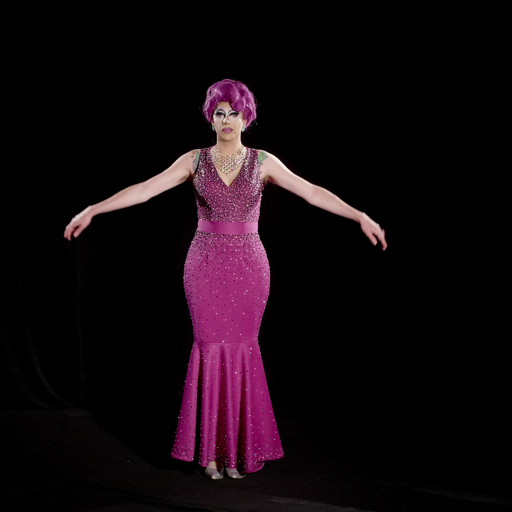

In [6]:
def img_to_pil(dataset, idx):
    img_dir = os.path.join(dataset.img_dir, dataset.img_files[idx])
    return Image.open(img_dir).resize((dataset.image_size, dataset.image_size))

img_to_pil(dataset, 33)

In [7]:
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        img_tens = transforms.ToTensor()(input_im).unsqueeze(0)*2-1 # Note scaling
        print(img_tens.shape)
        latent = vae.encode(img_tens.to("mps"))
    return 0.18215 * latent.latent_dist.sample()

In [8]:
latent = pil_to_latent(img_to_pil(dataset, 33))

torch.Size([1, 3, 512, 512])


In [9]:
# 4 * 64 * 64 = 16384
# image size is 3 * 512 * 512 = 786432
# 48x reduction
latent.shape

torch.Size([1, 4, 64, 64])

In [10]:
def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

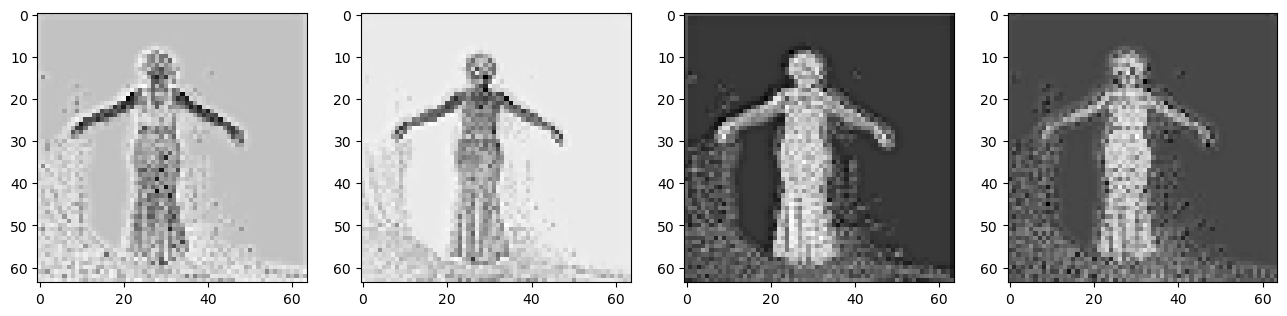

In [11]:
fig, axs = plt.subplots(1, 4, figsize=(16,4))
for c in range(4):
    axs[c].imshow(latent[0][c].cpu(), cmap='Greys')

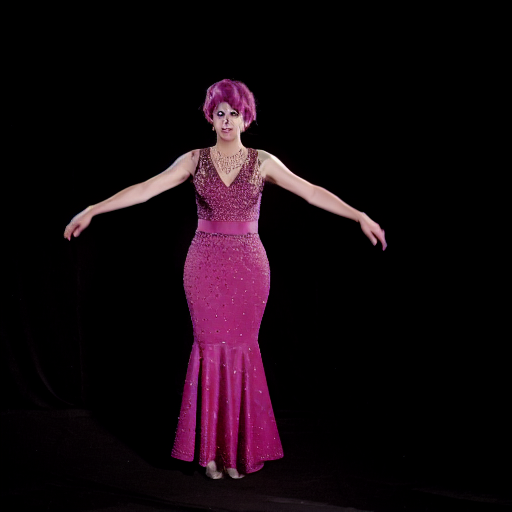

In [12]:
latents_to_pil(latent)[0]

In [13]:
from diffusers import DDPMScheduler

In [32]:
scheduler = DDPMScheduler(num_train_timesteps=1000)

sampling_step=90
scheduler.set_timesteps(100)

In [33]:
noisy = scheduler.add_noise(latent, torch.randn_like(latent), timesteps=torch.tensor([scheduler.timesteps[sampling_step]]))

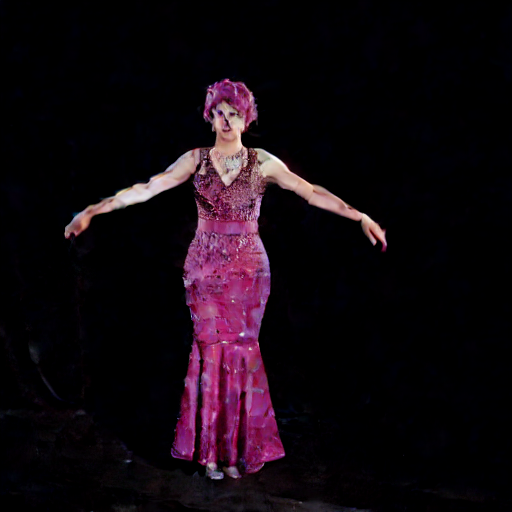

In [34]:
latents_to_pil(noisy.float())[0] # Display